<a href="https://colab.research.google.com/github/Solostriker/SunkalpChandra-HTHS-Research-Project/blob/main/research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn tensorflow matplotlib seaborn xgboost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from subprocess import check_output
import seaborn as sn
import math
from keras.layers import TimeDistributed
from keras.constraints import non_neg
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [ ]:
filepath = '/content/sample_data/data.csv'

df = pd.read_csv(filepath)

print(df.head())
print(df.columns)

       date  l_ipn  r_asn  f  suspicious
0  7/1/2006      0    701  1         NaN
1  7/1/2006      0    714  1         NaN
2  7/1/2006      0   1239  1         NaN
3  7/1/2006      0   1680  1         NaN
4  7/1/2006      0   2514  1         NaN
Index(['date', 'l_ipn', 'r_asn', 'f', 'suspicious'], dtype='object')


In [ ]:
df['date'] = pd.to_datetime(df['date'])

result_df = pd.DataFrame(columns=df.columns)

for date, group_date in df.groupby('date'):
    for ipn, group_ipn in group_date.groupby('l_ipn'):
        sum_values = group_ipn.sum()

        result_df = result_df.append(sum_values, ignore_index=True)

result_df['date'] = pd.to_datetime(result_df['date'])

<ipython-input-7-5fa7a4b9da63>:7: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sum_values = group_ipn.sum()
<ipython-input-7-5fa7a4b9da63>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(sum_values, ignore_index=True)
<ipython-input-7-5fa7a4b9da63>:7: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sum_values = group_ipn.sum()
<ipython-input-7-5fa7a4b9da63>:9: FutureWarning: The frame.append method is deprecated and 

In [ ]:
df['date'] = pd.to_datetime(df['date'])

result_df = df.groupby(['date', 'l_ipn', df['date'].dt.dayofyear, df['date'].dt.dayofweek], as_index=False).sum()

df['yday'] = df['date'].dt.dayofyear
df['wday'] = df['date'].dt.dayofweek

In [ ]:
max_values = df.groupby('l_ipn')['f'].agg(np.max)

max0 = max_values.get(0, 0)
max1 = max_values.get(1, 0)
max2 = max_values.get(2, 0)
max3 = max_values.get(3, 0)
max4 = max_values.get(4, 0)
max5 = max_values.get(5, 0)
max6 = max_values.get(6, 0)
max7 = max_values.get(7, 0)
max8 = max_values.get(8, 0)
max9 = max_values.get(9, 0)

In [ ]:
ip0 = df[df['l_ipn'] == 0]

num_bins = 10

ip0['bin'] = pd.cut(ip0['f'], bins=num_bins, include_lowest=True, labels=False)

count = ip0['bin'].value_counts().sort_index().to_numpy()
division = pd.cut(ip0['f'], bins=num_bins, include_lowest=True).cat.categories.to_numpy()

<ipython-input-10-3114760e758f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ip0['bin'] = pd.cut(ip0['f'], bins=num_bins, include_lowest=True, labels=False)


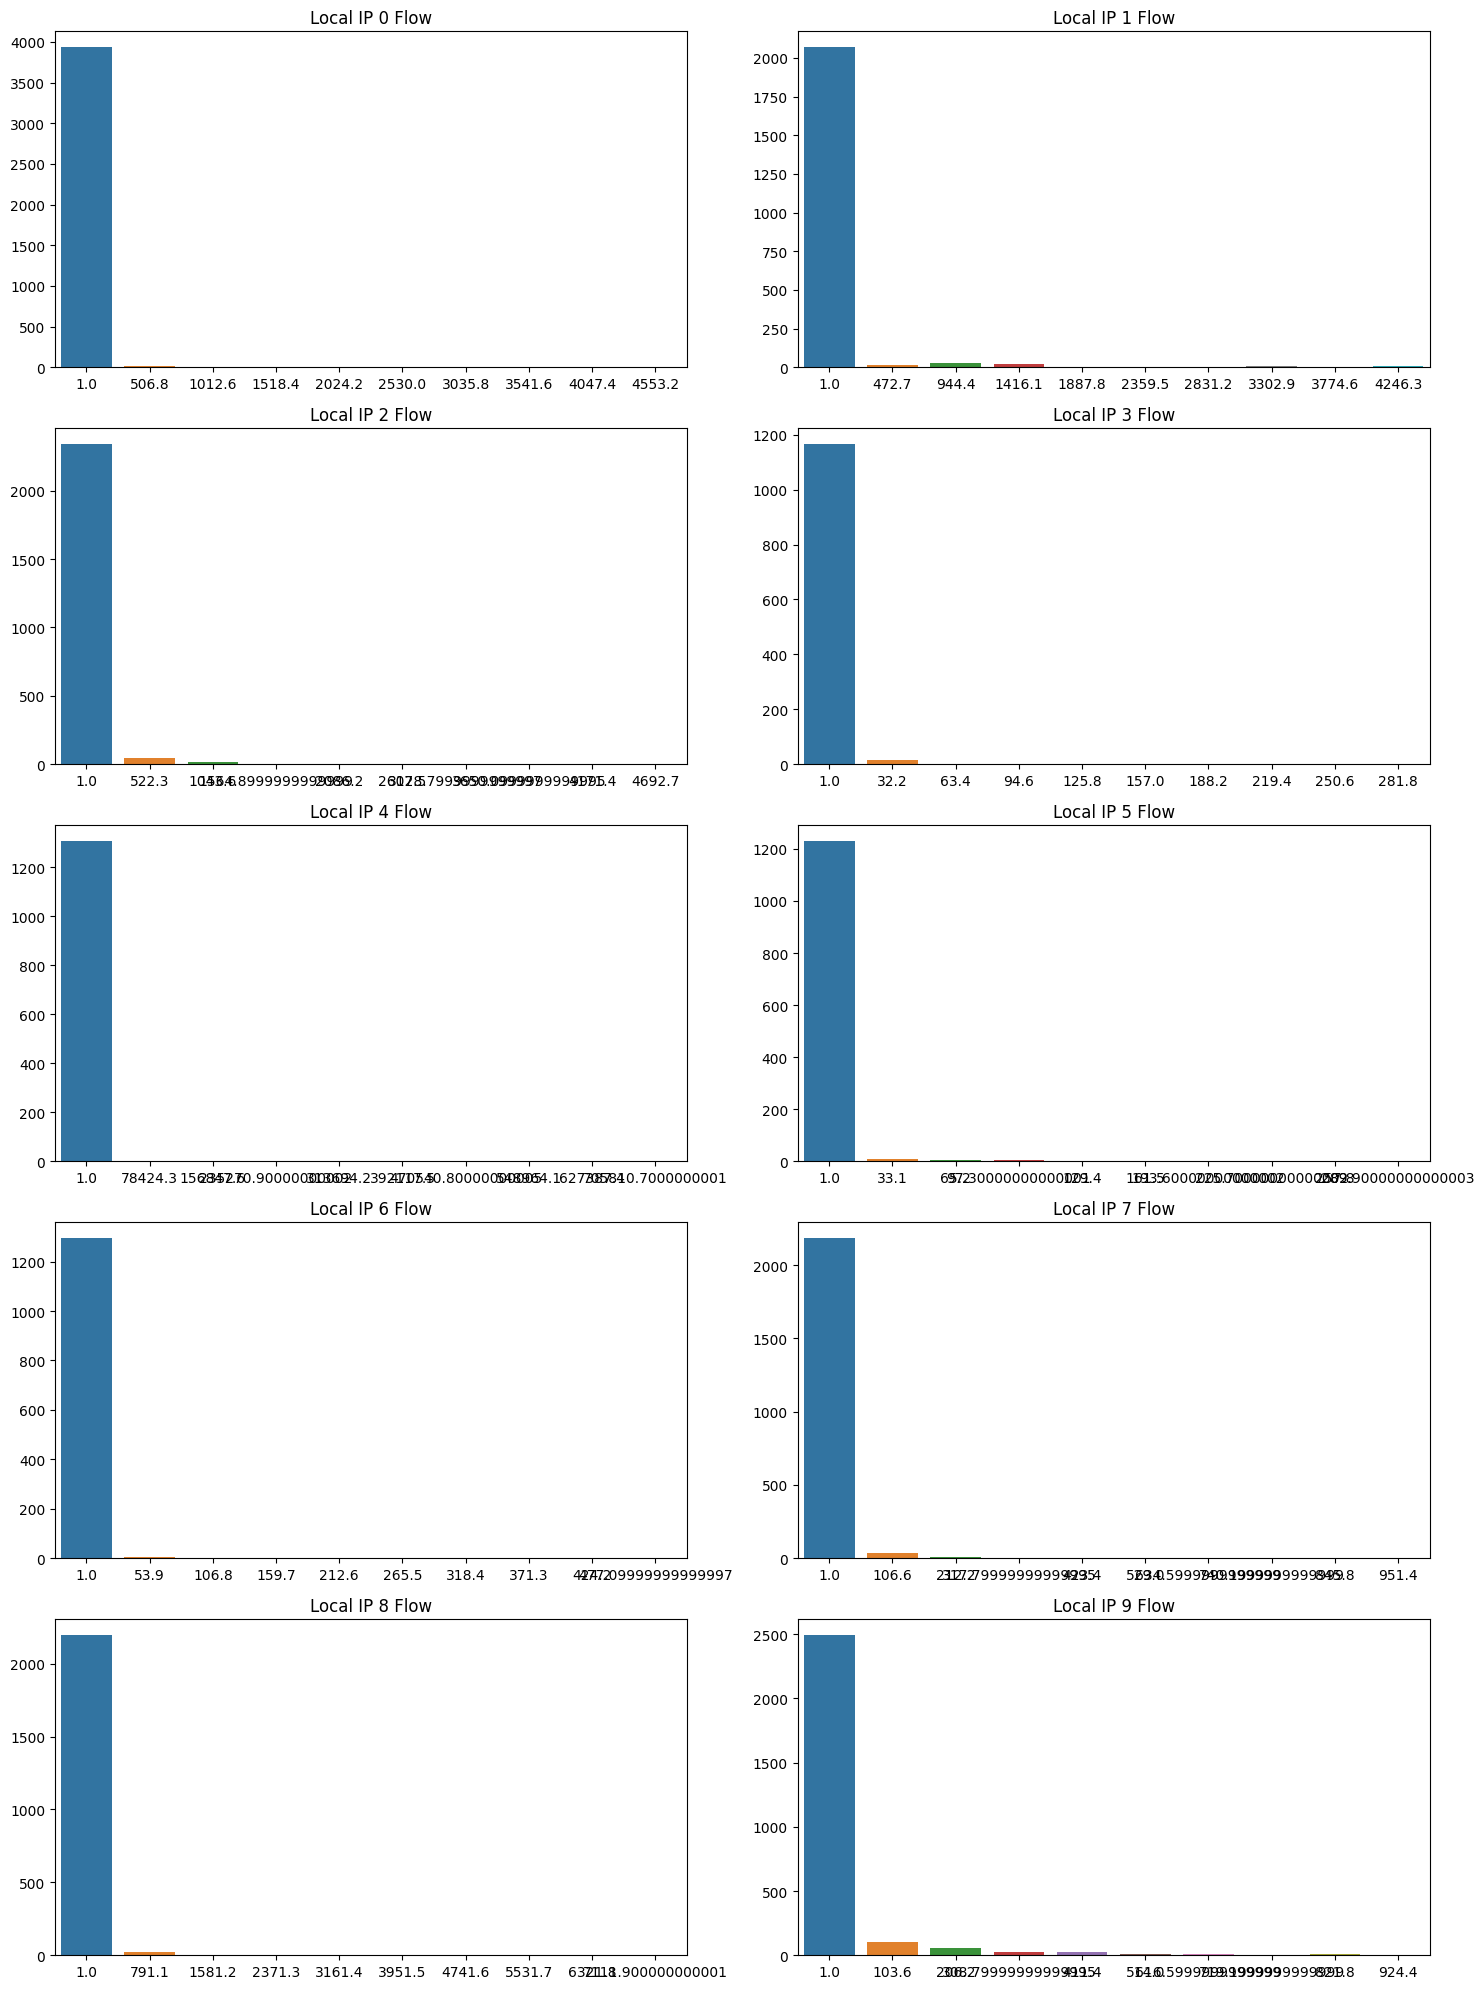

In [ ]:
f, axarray = plt.subplots(5, 2, figsize=(15, 20))

for i in range(10):
    count, division = np.histogram(df[df['l_ipn'] == i]['f'], bins=10)
    sn.barplot(x=division[0:len(division)-1], y=count, ax=axarray[i // 2, i % 2])
    axarray[i // 2, i % 2].set_title(f"Local IP {i} Flow")

plt.tight_layout()
plt.show()

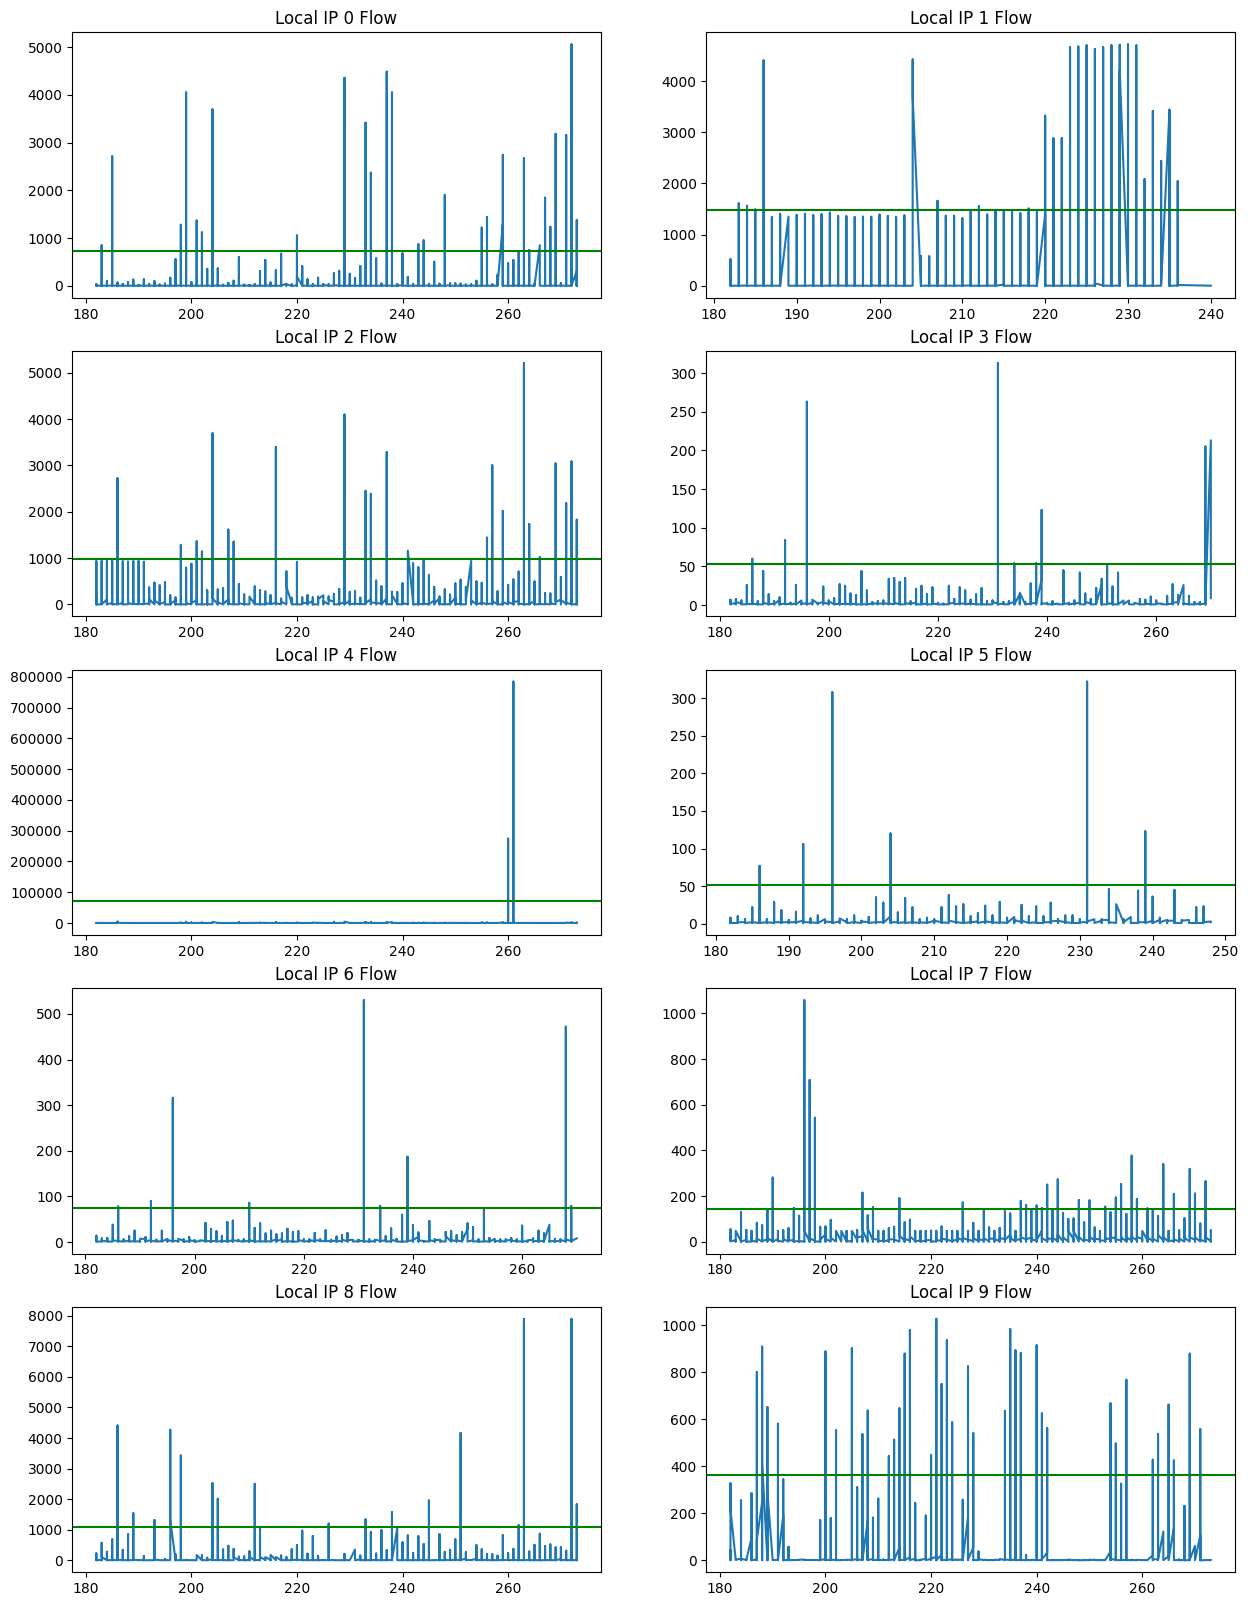

In [ ]:
f, axarray = plt.subplots(5, 2, figsize=(15, 20))

for i in range(10):
    ip_data = df[df['l_ipn'] == i]
    ax = axarray[i // 2, i % 2]

    if not ip_data.empty:
        ax.plot(ip_data['yday'], ip_data['f'])
        ax.set_title(f"Local IP {i} Flow")

        ax.axhline(y=ip_data['f'].mean() + 3 * ip_data['f'].std(ddof=0), color='g')

plt.show()


In [ ]:
def return_max_and_adjust(data, adjust_length=0):
    subset = data[:len(data)-adjust_length]
    max_value = np.max(subset['f'])
    return subset, max_value

ip0, max0 = return_max_and_adjust(df[df['l_ipn'] == 0])
ip1, max1 = return_max_and_adjust(df[df['l_ipn'] == 1], adjust_length=5)
ip2, max2 = return_max_and_adjust(df[df['l_ipn'] == 2])
ip3, max3 = return_max_and_adjust(df[df['l_ipn'] == 3])
ip4, max4 = return_max_and_adjust(df[df['l_ipn'] == 4], adjust_length=7)
ip5, max5 = return_max_and_adjust(df[df['l_ipn'] == 5])
ip6, max6 = return_max_and_adjust(df[df['l_ipn'] == 6])
ip7, max7 = return_max_and_adjust(df[df['l_ipn'] == 7])
ip8, max8 = return_max_and_adjust(df[df['l_ipn'] == 8])
ip9, max9 = return_max_and_adjust(df[df['l_ipn'] == 9])

print(f"Local IP 0: Max = {max0}\n", ip0.head(2))
print(f"Local IP 1: Max = {max1}\n", ip1.head(2))
print(f"Local IP 2: Max = {max2}\n", ip2.head(2))
print(f"Local IP 3: Max = {max3}\n", ip3.head(2))
print(f"Local IP 4: Max = {max4}\n", ip4.head(2))
print(f"Local IP 5: Max = {max5}\n", ip5.head(2))
print(f"Local IP 6: Max = {max6}\n", ip6.head(2))
print(f"Local IP 7: Max = {max7}\n", ip7.head(2))
print(f"Local IP 8: Max = {max8}\n", ip8.head(2))
print(f"Local IP 9: Max = {max9}\n", ip9.head(2))


Local IP 0: Max = 5059
         date  l_ipn  r_asn  f  suspicious  yday  wday
0 2006-07-01      0    701  1         NaN   182     5
1 2006-07-01      0    714  1         NaN   182     5
Local IP 1: Max = 4718
          date  l_ipn  r_asn  f  suspicious  yday  wday
35 2006-07-01      1    680  1         NaN   182     5
36 2006-07-01      1   1239  6         NaN   182     5
Local IP 2: Max = 5214
          date  l_ipn  r_asn    f  suspicious  yday  wday
54 2006-07-01      2   1312  218         NaN   182     5
55 2006-07-01      2   3561    8         NaN   182     5
Local IP 3: Max = 313
          date  l_ipn  r_asn  f  suspicious  yday  wday
69 2006-07-01      3   1239  1         NaN   182     5
70 2006-07-01      3   2152  1         NaN   182     5
Local IP 4: Max = 784234
          date  l_ipn  r_asn  f  suspicious  yday  wday
78 2006-07-01      4   1239  5         NaN   182     5
79 2006-07-01      4   1668  1         NaN   182     5
Local IP 5: Max = 322
          date  l_ipn  r_asn 

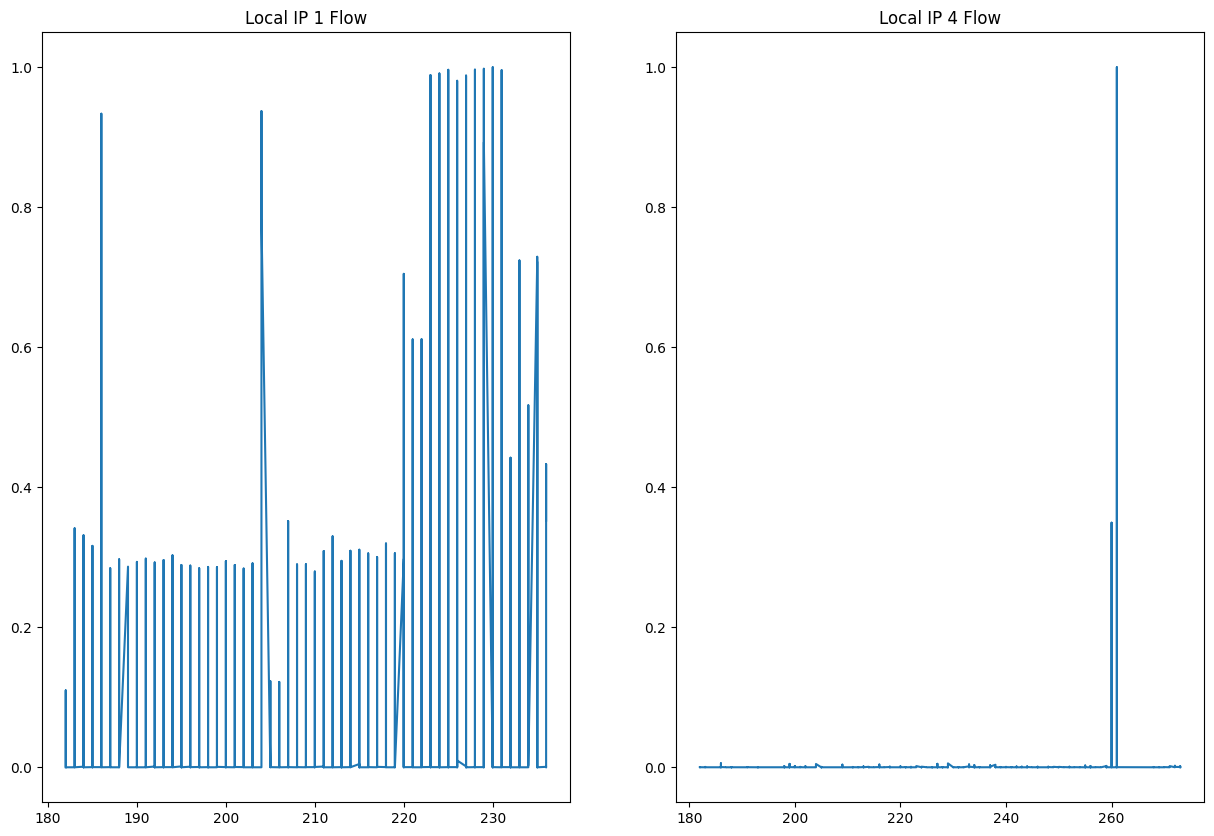

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

axes[0].plot(ip1['yday'], ip1['f'])
axes[0].set_title("Local IP 1 Flow")

axes[1].plot(ip4['yday'], ip4['f'])
axes[1].set_title("Local IP 4 Flow")

plt.show()

<ipython-input-24-7c65257294f4>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sn.barplot(x=local_ip.groupby('wday', as_index=False).sum()['wday'],
<ipython-input-24-7c65257294f4>:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y=local_ip.groupby('wday', as_index=False).sum()['f'].values,
<ipython-input-24-7c65257294f4>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sn.barplot(x=local_ip.groupby('wday', as_index=Fal

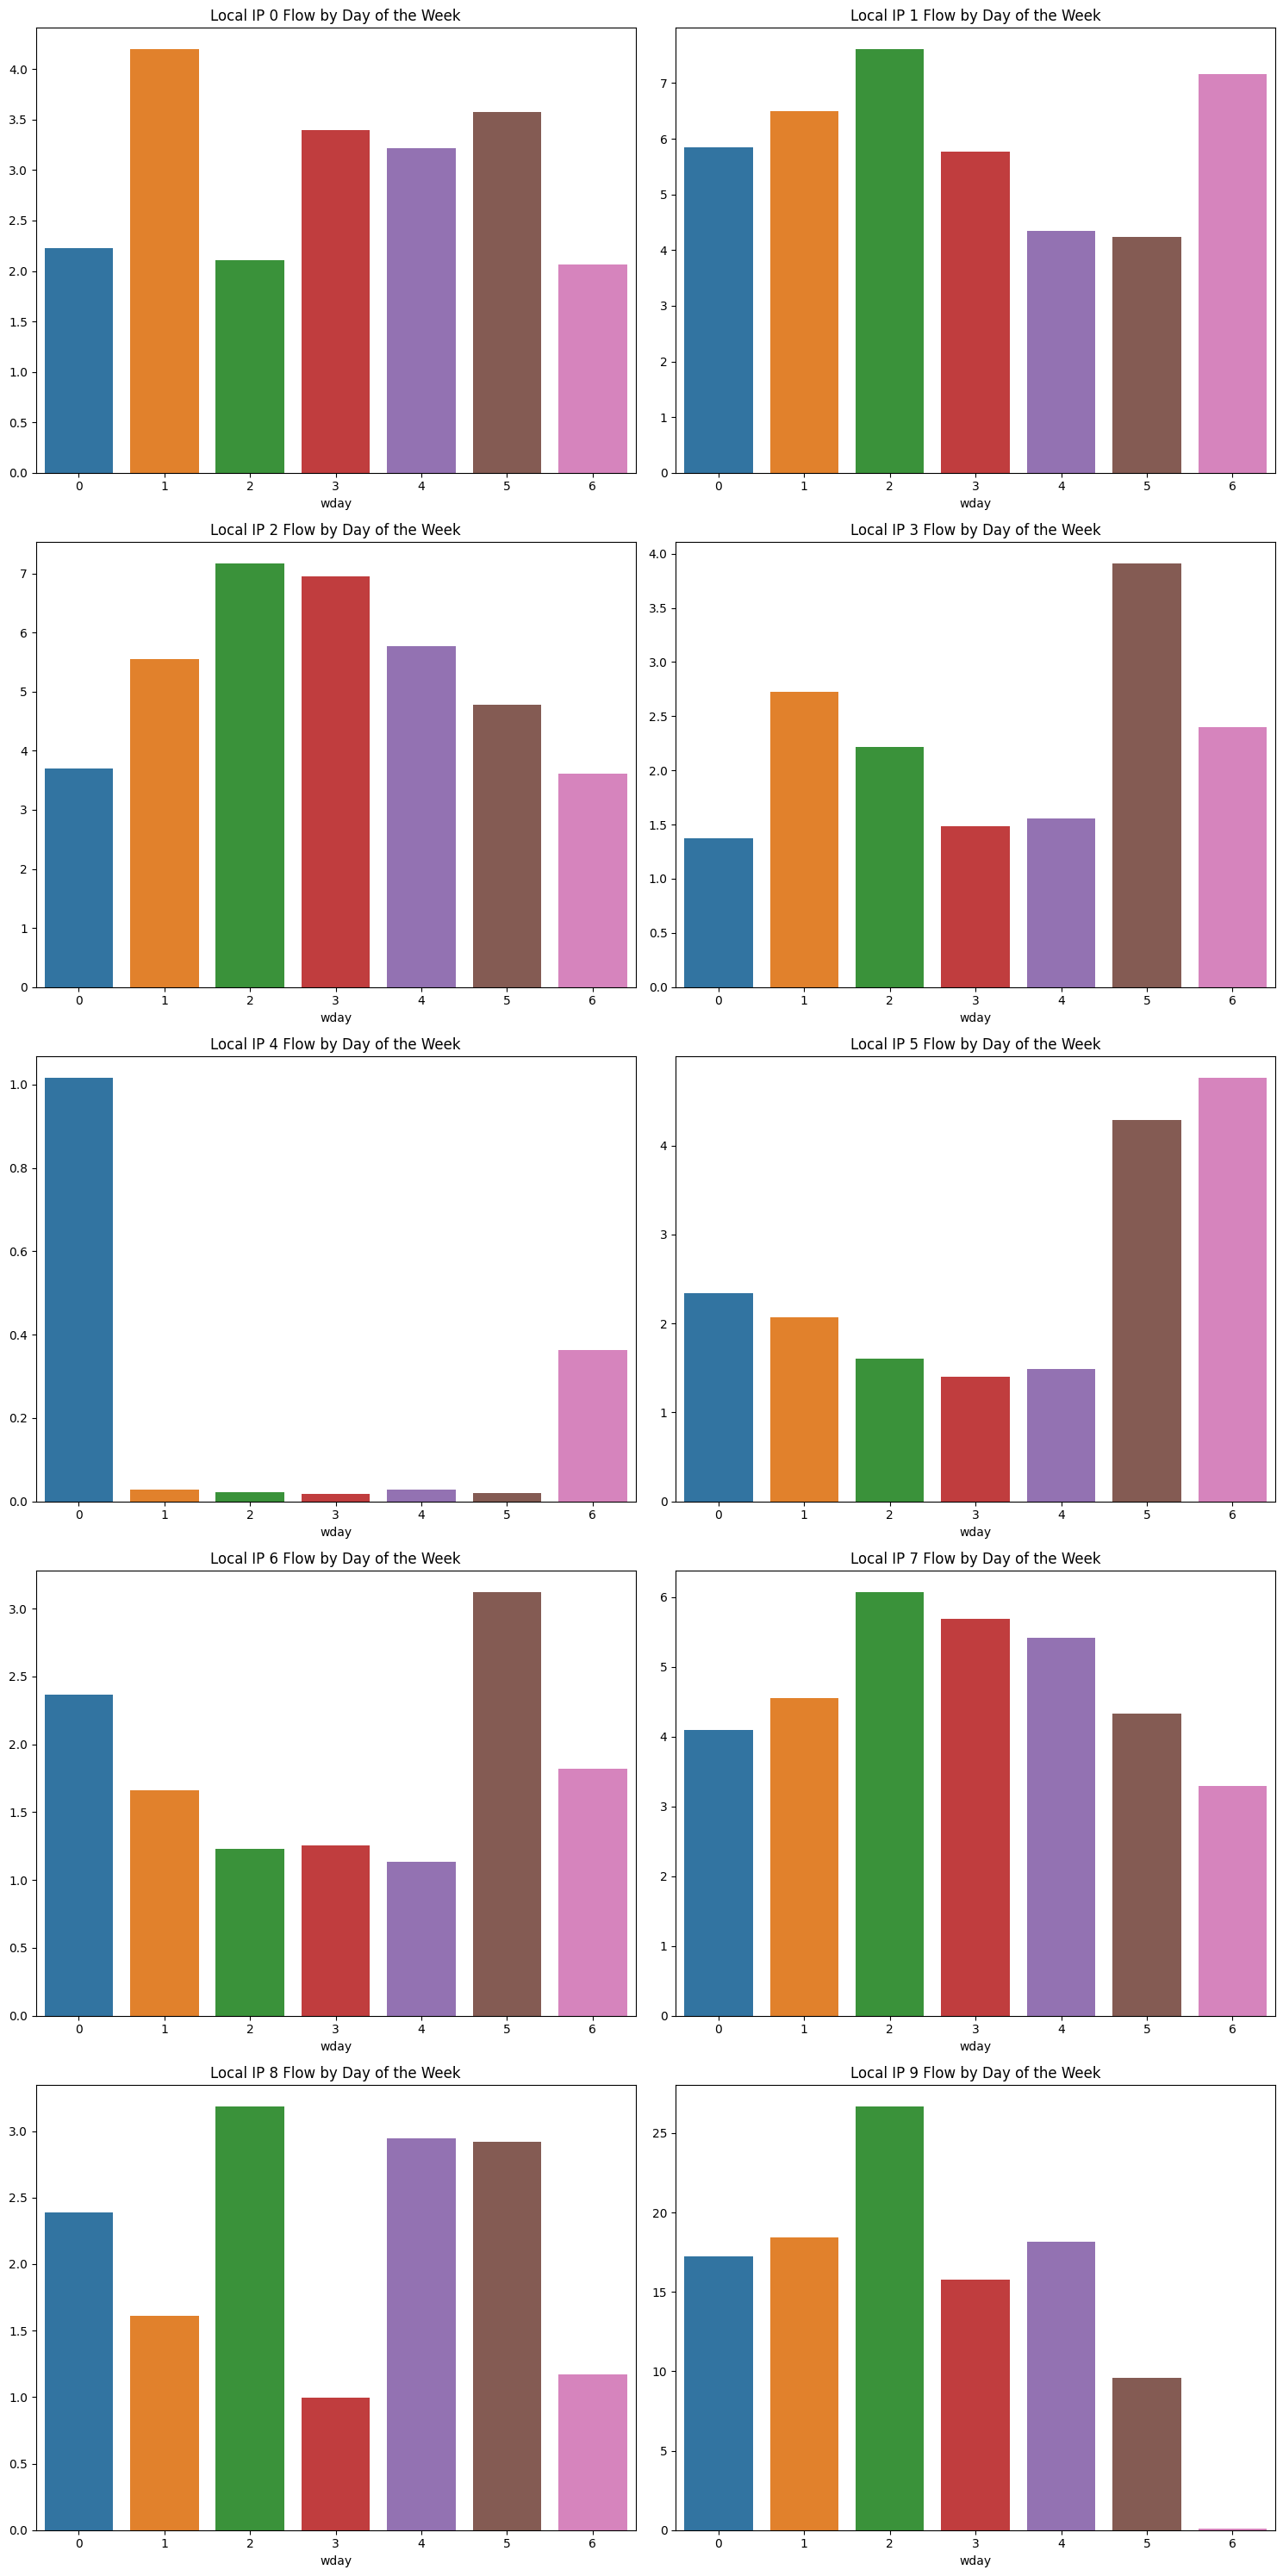

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(15, 30))

local_ips = [ip0, ip1, ip2, ip3, ip4, ip5, ip6, ip7, ip8, ip9]

for i, (local_ip, ax) in enumerate(zip(local_ips[:10], axes.flatten())):
    sn.barplot(x=local_ip.groupby('wday', as_index=False).sum()['wday'],
                y=local_ip.groupby('wday', as_index=False).sum()['f'].values,
                ax=ax)
    ax.set_title(f"Local IP {i} Flow by Day of the Week")

plt.tight_layout()
plt.show()


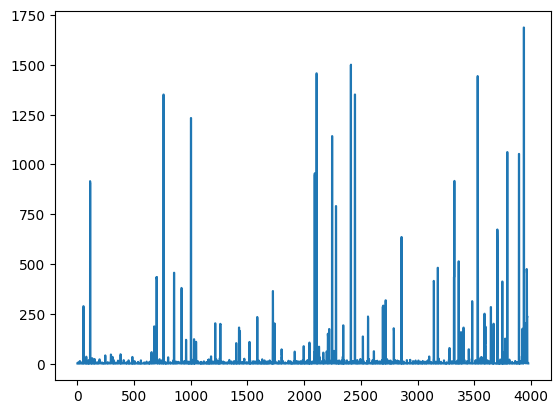

In [ ]:
rolling_mean = np.convolve(ip0['f'], np.ones(3)/3, mode='valid')

plt.plot(range(len(rolling_mean)), rolling_mean)
plt.show()

In [ ]:
ip_frames = [ip0, ip1, ip2, ip3, ip4, ip5, ip6, ip7, ip8, ip9]
max_values = [max0, max1, max2, max3, max4, max5, max6, max7, max8, max9]

for i, ip_frame in enumerate(ip_frames):
    max_value = max_values[i]
    fv = ip_frame['f'] / max_value
    ip_frame['f'] = fv.values.reshape(-1, 1)

In [ ]:
def create_dataset(dataset, previous_time_steps_to_be_used_to_predict=1):
    dataX, dataY = [], []

    for i in range(len(dataset) - previous_time_steps_to_be_used_to_predict):
        seq_X = dataset.iloc[i:i+previous_time_steps_to_be_used_to_predict, :].values
        seq_Y = dataset.iloc[i + previous_time_steps_to_be_used_to_predict, dataset.columns.get_loc('f')]

        dataX.append(seq_X)
        dataY.append(seq_Y)

    return np.array(dataX), np.array(dataY)

In [ ]:
def training_model(data, previous_time_steps_to_be_used_to_predict=14, units_gru1=64, units_gru2=32, epochs=100, batch_size=16):
    data['f'] = data['f'].astype('float32')

    train = data.iloc[:previous_time_steps_to_be_used_to_predict * 5].copy()
    train_X, train_Y = create_dataset(train, previous_time_steps_to_be_used_to_predict)

    train_X = np.reshape(train_X, (train_X.shape[0], previous_time_steps_to_be_used_to_predict, 2))

    model = Sequential([
        GRU(units_gru1, input_shape=(previous_time_steps_to_be_used_to_predict, 2), return_sequences=True),
        GRU(units_gru2),
        Dense(1)
    ])

    model.compile(loss='mean_squared_error', optimizer='sgd')

    model.fit(train_X, train_Y, epochs=100, batch_size=16, verbose=0)

    return model


In [ ]:
def predict_flow(_model, data):
    y_pred = [0] * previous_time_steps_to_be_used_to_predict
    for k in range(len(data) - previous_time_steps_to_be_used_to_predict):
        pattern = data.iloc[k:k + previous_time_steps_to_be_used_to_predict].values
        x = np.reshape(pattern, (1, len(pattern), 2))
        y_pred.append(_model.predict(x)[0][0])
    return y_pred


In [ ]:
m0 = training_model(ip0[['f','wday']].copy())
m1 = training_model(ip1[['f','wday']].copy())
m2 = training_model(ip2[['f','wday']].copy())
m3 = training_model(ip3[['f','wday']].copy())
m4 = training_model(ip4[['f','wday']].copy())
m5 = training_model(ip5[['f','wday']].copy())
m6 = training_model(ip6[['f','wday']].copy())
m7 = training_model(ip7[['f','wday']].copy())
m8 = training_model(ip8[['f','wday']].copy())
m9 = training_model(ip9[['f','wday']].copy())

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 29ms/step


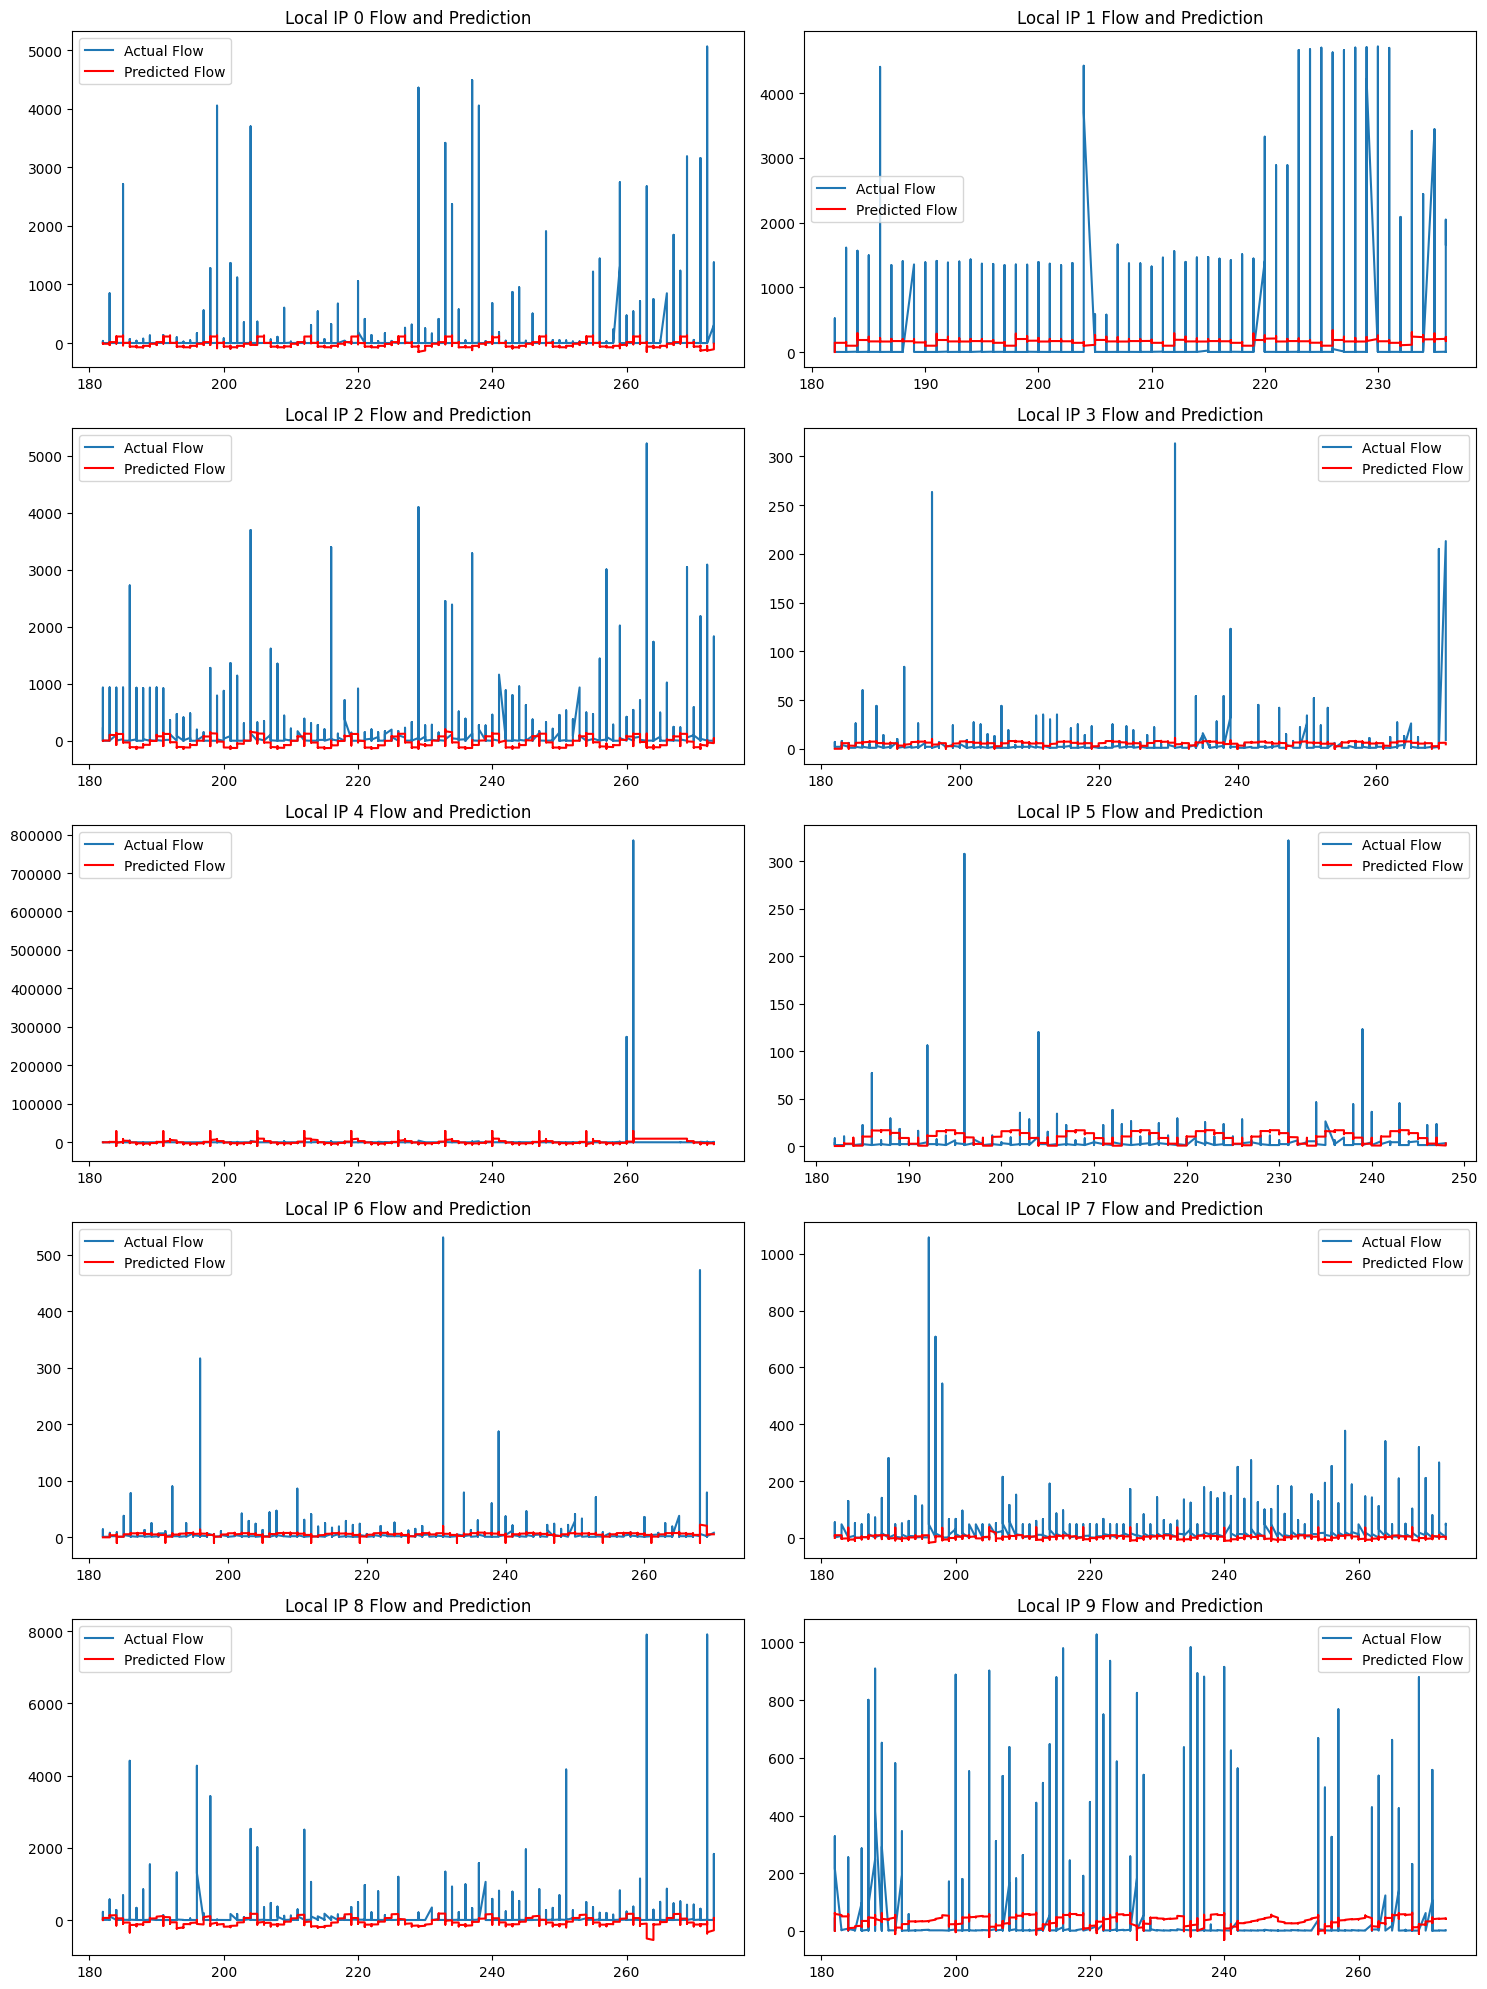

In [ ]:
previous_time_steps_to_be_used_to_predict = 14
f, axarray = plt.subplots(5, 2, figsize=(15, 20))

local_ips = [ip0, ip1, ip2, ip3, ip4, ip5, ip6, ip7, ip8, ip9]
models = [m0, m1, m2, m3, m4, m5, m6, m7, m8, m9]
max_values = [max0, max1, max2, max3, max4, max5, max6, max7, max8, max9]

for i in range(5):
    for j in range(2):
        ip = local_ips[i * 2 + j]
        ypred = np.multiply(predict_flow(models[i * 2 + j], ip[['f', 'wday']].copy()), max_values[i * 2 + j])
        ipf = np.multiply(ip['f'], max_values[i * 2 + j])

        axarray[i, j].plot(ip['yday'], ipf, label='Actual Flow')
        axarray[i, j].plot(ip['yday'], ypred, color='r', alpha=1, label='Predicted Flow')
        axarray[i, j].set_title(f"Local IP {i * 2 + j} Flow and Prediction")
        axarray[i, j].legend()

plt.tight_layout()
plt.show()


In [ ]:
corr_list = []
for i in range(10):
    actual_flow = np.multiply(locals()[f'ip{i}']['f'], locals()[f'max{i}'])
    predicted_flow = np.multiply(predict_flow(locals()[f'm{i}'], locals()[f'ip{i}'][['f', 'wday']].copy()), locals()[f'max{i}'])
    corr = pd.Series(actual_flow).corr(pd.Series(predicted_flow))
    corr_list.append(corr)

corrdf = pd.DataFrame({f'corr{i}': corr_list[i] for i in range(10)}, index=[0])
corrdf.head()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 34ms/step


,corr0,corr1,corr2,corr3,corr4,corr5,corr6,corr7,corr8,corr9
0,0.067312,0.049031,-0.015535,0.16273,0.000572,-0.115148,0.093535,-0.084291,0.007891,0.022079


In [ ]:
corr_list = []
mse_list = []
mae_list = []
r2_list = []
rmse_list = []
previous_time_steps_to_be_used_to_predict = 14

for i in range(10):
    actual_flow = np.multiply(locals()[f'ip{i}']['f'], locals()[f'max{i}'])
    predicted_flow = np.multiply(predict_flow(locals()[f'm{i}'], locals()[f'ip{i}'][['f', 'wday']].copy()), locals()[f'max{i}'])

    corr = pd.Series(actual_flow).corr(pd.Series(predicted_flow))
    corr_list.append(corr)

    mse = mean_squared_error(actual_flow, predicted_flow)
    mae = mean_absolute_error(actual_flow, predicted_flow)
    r2 = r2_score(actual_flow, predicted_flow)
    rmse = np.sqrt(mse)

    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)
    rmse_list.append(rmse)

metrics_df = pd.DataFrame({
    f'corr{i}': corr_list,
    f'mse{i}': mse_list,
    f'mae{i}': mae_list,
    f'r2{i}': r2_list,
    f'rmse{i}': rmse_list
}, index=[0])

metrics_df.head()

1/1 [==============================] - 0s 23ms/step
